# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
#from ddpg_agent import Agent
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64', worker_id=21, seed=1)

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher-2')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):

    def __init__(self, state_size, action_size, use_batch_norm, seed,
                 fc1_units=600, fc2_units=200):
        """
        :param state_size: Dimension of each state
        :param action_size: Dimension of each state
        :param seed: random seed
        :param use_batch_norm: True to use batch norm
        :param fc1_units: number of nodes in 1st hidden layer
        :param fc2_units: number of nodes in 2nd hidden layer
        """
        super(Actor, self).__init__()

        if seed is not None:
            torch.manual_seed(seed)

        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(state_size)
            self.bn2 = nn.BatchNorm1d(fc1_units)
            self.bn3 = nn.BatchNorm1d(fc2_units)

        # batch norm has bias included, disable linear layer bias
        use_bias = not use_batch_norm

        self.use_batch_norm = use_batch_norm
        self.fc1 = nn.Linear(state_size, fc1_units, bias=use_bias)
        self.fc2 = nn.Linear(fc1_units, fc2_units, bias=use_bias)
        self.fc3 = nn.Linear(fc2_units, action_size, bias=use_bias)
        self.reset_parameters()

    def forward(self, state):
        """ map a states to action values
        :param state: shape == (batch, state_size)
        :return: action values
        """

        if self.use_batch_norm:
            x = F.relu(self.fc1(self.bn1(state)))
            x = F.relu(self.fc2(self.bn2(x)))
            return torch.tanh(self.fc3(self.bn3(x)))
        else:
            x = F.leaky_relu(self.fc1(state))
            x = F.leaky_relu(self.fc2(x))
            return torch.tanh(self.fc3(x))

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)


class Critic(nn.Module):

    def __init__(self, state_size, action_size, use_batch_norm, seed,
                 fc1_units=600, fc2_units=200):
        """
        :param duel_network: boolean
        :param state_size: Dimension of each state
        :param action_size: Dimension of each state
        :param seed: random seed
        :param fc1_units: number of nodes in 1st hidden layer
        :param fc2_units: number of nodes in 2nd hidden layer
        """
        super(Critic, self).__init__()

        if seed is not None:
            torch.manual_seed(seed)

        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(state_size)

        # batch norm has bias included, disable linear layer bias
        use_bias = not use_batch_norm

        self.use_batch_norm = use_batch_norm
        self.fc1 = nn.Linear(state_size, fc1_units, bias=use_bias)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def forward(self, state, action):
        """ map (states, actions) pairs to Q-values
        :param state: shape == (batch, state_size)
        :param action: shape == (batch, action_size)
        :return: q-values values
        """

        if self.use_batch_norm:
            x = F.relu(self.fc1(self.bn1(state)))
        else:
            x = F.relu(self.fc1(state))

        x = torch.cat((x, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed, hyper):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = hyper['EPSILON']

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, hyper['USE_BATCH_NORM'] ,random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, hyper['USE_BATCH_NORM'] ,random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=hyper['LR_ACTOR'])

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, hyper['USE_BATCH_NORM']  ,random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, hyper['USE_BATCH_NORM'] ,random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=hyper['LR_CRITIC'], weight_decay=hyper['WEIGHT_DECAY'])

        # Noise process
        self.noise = OUNoise(action_size, random_seed, hyper['NOISE_SIGMA'])

        # Replay memory
        self.memory = ReplayBuffer(action_size, hyper['BUFFER_SIZE'], hyper['BATCH_SIZE'], random_seed)

    def step(self, states, actions, rewards, next_states, dones, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > hyper['BATCH_SIZE'] and timestep % hyper['UPDATE_EVERY'] == 0:
            for _ in range(hyper['NUM_UPDATES']):
                experiences = self.memory.sample()
                self.learn(experiences, hyper['GAMMA'])

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() 
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + ? * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, hyper['TAU'])
        self.soft_update(self.actor_local, self.actor_target, hyper['TAU'])

        # ---------------------------- update noise ---------------------------- #
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        ?_target = t*?_local + (1 - t)*?_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_copy(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)


In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, sigma, mu=0., theta=0.15, eps=1, eps_decay=0):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.eps = eps
        self.eps_decay = eps_decay
        self.reset()
        
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        self.eps -= self.eps_decay
        
    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [10]:
def ddpg(n_episodes=200):
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    best_avg = -np.inf
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
                
        print('\rEpisode {}, Average Score: {:.2f}'.format(i_episode, score_average, end=""))        
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_%s.pth' % i_episode)
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_%s.pth' % i_episode)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            
        if score_average >= 30:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))
            torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
            return scores_global, average_global
            break


In [11]:
import time
from itertools import count


In [12]:
hyper = {'BUFFER_SIZE' : int(1e6)  # replay buffer size
,'BATCH_SIZE' : 256        # minibatch size
,'GAMMA' : 0.99            # discount factor
,'TAU' : 1e-3              # for soft update of target parameters
,'LR_ACTOR' : 1e-3         # learning rate of the actor
,'LR_CRITIC' : 1e-3        # learning rate of the critic
,'WEIGHT_DECAY' : 0        # L2 weight decay
,'UPDATE_EVERY' : 20       # timesteps between updates
,'NUM_UPDATES' : 10        # num of update passes when updating
,'EPSILON' : 1.0           # epsilon for the noise process added to the actions
,'EPSILON_DECAY' : 0    # decay for epsilon above
,'NOISE_SIGMA' : 0.01      # sigma for Ornstein-Uhlenbeck noise
,'USE_BATCH_NORM' : False }

agent = Agent(state_size, action_size, random_seed=15, hyper=hyper)
avg_over = 100
print_every = 10
scores_h1, averages_h1 = ddpg()

Episode 1, Average Score: 0.27
Episode 2, Average Score: 0.29
Episode 3, Average Score: 0.60
Episode 4, Average Score: 0.61
Episode 5, Average Score: 0.50
Episode 6, Average Score: 0.42
Episode 7, Average Score: 0.36
Episode 8, Average Score: 0.37
Episode 9, Average Score: 0.45
Episode 10, Average Score: 0.47
Episode 10	Average Score: 0.47
Episode 11, Average Score: 0.48
Episode 12, Average Score: 0.49
Episode 13, Average Score: 0.54
Episode 14, Average Score: 0.57
Episode 15, Average Score: 0.58
Episode 16, Average Score: 0.61
Episode 17, Average Score: 0.59
Episode 18, Average Score: 0.63
Episode 19, Average Score: 0.65
Episode 20, Average Score: 0.68
Episode 20	Average Score: 0.68
Episode 21, Average Score: 0.69
Episode 22, Average Score: 0.67
Episode 23, Average Score: 0.65
Episode 24, Average Score: 0.66
Episode 25, Average Score: 0.64
Episode 26, Average Score: 0.63
Episode 27, Average Score: 0.66
Episode 28, Average Score: 0.68
Episode 29, Average Score: 0.71
Episode 30, Average

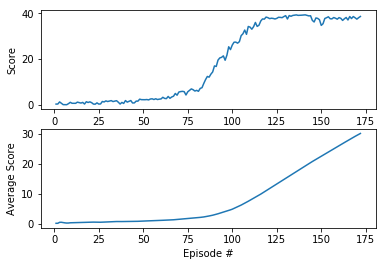

In [15]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(scores_h1)+1), scores_h1)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(scores_h1)+1), averages_h1)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [17]:
with open('averages_h1.txt', 'w') as f:
    for item in averages_h1:
        f.write("%s\n" % item)
        
with open('scores_h1.txt', 'w') as f:
    for item in scores_h1:
        f.write("%s\n" % item)

In [18]:
hyper = {'BUFFER_SIZE' : int(1e6)  # replay buffer size
,'BATCH_SIZE' : 256        # minibatch size
,'GAMMA' : 0.99            # discount factor
,'TAU' : 1e-3              # for soft update of target parameters
,'LR_ACTOR' : 1e-3         # learning rate of the actor
,'LR_CRITIC' : 1e-3        # learning rate of the critic
,'WEIGHT_DECAY' : 0        # L2 weight decay
,'UPDATE_EVERY' : 20       # timesteps between updates
,'NUM_UPDATES' : 10        # num of update passes when updating
,'EPSILON' : 1.0           # epsilon for the noise process added to the actions
,'EPSILON_DECAY' : 0    # decay for epsilon above
,'NOISE_SIGMA' : 0.01      # sigma for Ornstein-Uhlenbeck noise
,'USE_BATCH_NORM' : True }

agent = Agent(state_size, action_size, random_seed=15, hyper=hyper)
avg_over = 100
print_every = 10
scores_h2, averages_h2 = ddpg()


Episode 1, Average Score: 0.80
Episode 2, Average Score: 0.84
Episode 3, Average Score: 0.90
Episode 4, Average Score: 0.90
Episode 5, Average Score: 0.86
Episode 6, Average Score: 0.83
Episode 7, Average Score: 0.73
Episode 8, Average Score: 0.65
Episode 9, Average Score: 0.60
Episode 10, Average Score: 0.61
Episode 10	Average Score: 0.61
Episode 11, Average Score: 0.60
Episode 12, Average Score: 0.58
Episode 13, Average Score: 0.61
Episode 14, Average Score: 0.67
Episode 15, Average Score: 0.69
Episode 16, Average Score: 0.72
Episode 17, Average Score: 0.75
Episode 18, Average Score: 0.79
Episode 19, Average Score: 0.81
Episode 20, Average Score: 0.83
Episode 20	Average Score: 0.83
Episode 21, Average Score: 0.85
Episode 22, Average Score: 0.87
Episode 23, Average Score: 0.91
Episode 24, Average Score: 0.94
Episode 25, Average Score: 0.92
Episode 26, Average Score: 0.91
Episode 27, Average Score: 0.94
Episode 28, Average Score: 0.94
Episode 29, Average Score: 0.93
Episode 30, Average

KeyboardInterrupt: 

In [ ]:
hyper = {'BUFFER_SIZE' : int(1e6)  # replay buffer size
,'BATCH_SIZE' : 256        # minibatch size
,'GAMMA' : 0.99            # discount factor
,'TAU' : 1e-3              # for soft update of target parameters
,'LR_ACTOR' : 1e-3         # learning rate of the actor
,'LR_CRITIC' : 1e-3        # learning rate of the critic
,'WEIGHT_DECAY' : 0        # L2 weight decay
,'UPDATE_EVERY' : 20       # timesteps between updates
,'NUM_UPDATES' : 10        # num of update passes when updating
,'EPSILON' : 1.0           # epsilon for the noise process added to the actions
,'EPSILON_DECAY' : 1e-6    # decay for epsilon above
,'NOISE_SIGMA' : 0.05      # sigma for Ornstein-Uhlenbeck noise
,'USE_BATCH_NORM' : False }

agent = Agent(state_size, action_size, random_seed=15, hyper=hyper)
avg_over = 100
print_every = 10
scores_h3, averages_h3 = ddpg()

In [ ]:
hyper = {'BUFFER_SIZE' : int(1e6)  # replay buffer size
,'BATCH_SIZE' : 256        # minibatch size
,'GAMMA' : 0.99            # discount factor
,'TAU' : 1e-3              # for soft update of target parameters
,'LR_ACTOR' : 1e-3         # learning rate of the actor
,'LR_CRITIC' : 1e-3        # learning rate of the critic
,'WEIGHT_DECAY' : 0        # L2 weight decay
,'UPDATE_EVERY' : 20       # timesteps between updates
,'NUM_UPDATES' : 10        # num of update passes when updating
,'EPSILON' : 1.0           # epsilon for the noise process added to the actions
,'EPSILON_DECAY' : 1e-6    # decay for epsilon above
,'NOISE_SIGMA' : 0.05      # sigma for Ornstein-Uhlenbeck noise
,'USE_BATCH_NORM' : True }

agent = Agent(state_size, action_size, random_seed=15, hyper=hyper)
avg_over = 100
print_every = 10
scores_h4, averages_h4 = ddpg()